# Preprocessing and refining the data

In [151]:
import pandas as pd

df = pd.read_csv('/content/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv')
df = df.dropna(subset=['Category', 'About Product'])
df.to_csv('data_cleaned.csv', index=False)

In [152]:
df[['Uniq Id','Product Name','Category','About Product']]

,Uniq Id,Product Name,Category,About Product
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,Make sure this fits by entering your model num...
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,Make sure this fits by entering your model num...
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,Make sure this fits by entering your model num...
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,Toys & Games | Hobbies | Models & Model Kits |...,Make 8 different Planes at one time. | Experim...
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,Toys & Games | Puzzles | Jigsaw Puzzles,Make sure this fits by entering your model num...
...,...,...,...,...
9995,ec8506d9915fb21052be5a529e32f61e,Cozy Line Home Fashions Size 2 Piece Ocean Cre...,Home & Kitchen | Bedding | Kids' Bedding | Qui...,Make sure this fits by entering your model num...
9996,0678767f2ff24c5c2330ed0d4456c199,"LEGO 8-Brick Storage Box, Bright Red",Toys & Games | Building Toys,Make sure this fits by entering your model num...
9998,e11514dcf1f087887cd5ea0bd646d1fc,Trends International NFL La Chargers HG - Mobi...,Toys & Games | Arts & Crafts,Make sure this fits by entering your model num...
9999,c00301a38560da2abc89c1f86ce4b267,NewPath Learning 10 Piece Science Owls and Owl...,Office Products | Office & School Supplies | E...,Make sure this fits by entering your model num...


In [153]:
cats = list(df['Category'])
u_cats = []
for cat in cats:
    temps = cat.split(' | ')
    u_cats += [temp for temp in temps if temp not in u_cats]

print(len(u_cats))

1151


In [154]:
def cat_vec(s):
    s = s.split(' | ')
    return ' '.join([str(u_cats.index(i)) for i in s])

cat_df = df[['Uniq Id', 'Category']]

cat_df['cat_vec'] = cat_df['Category'].apply(cat_vec)

In [155]:
cat_df.to_csv('cat_vec.csv', index=False)

In [156]:
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import string
import numpy as np

from time import time
start = time()
nltk.download('brown')
from nltk.corpus import brown
model = Word2Vec(brown.sents())
print(time()-start)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


46.9407262802124


In [157]:
def mean_vectorize(sent):
    sent = ''.join([char.lower() for char in sent if char not in string.punctuation])
    words = nltk.word_tokenize(sent)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    vectors = [model.wv[word] for word in words if word in model.wv]

    ret = np.mean(vectors, axis = 0)
    # print(ret)
    if np.isnan(ret).all():
        return np.nan
    else:
        return list(ret)

In [158]:
nltk.download('punkt')
nltk.download('stopwords')

l=[]

def desc_vect(sent):
    if '|' in sent:
        sent = sent[sent.index('|'):]
    vect = mean_vectorize(sent)
    return vect

desc_df = df[['Uniq Id', 'About Product']]

desc_df['desc_vec'] = np.array(desc_df['About Product'].apply(desc_vect))
desc_df = desc_df.dropna(subset=['desc_vec'])
# print(len(l))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [159]:
desc_vects = dict(desc_df[["Uniq Id", "desc_vec"]].values)
# print(desc_vects["2c55cae269aebf53838484b0d7dd931a"])
# import json
# with open('/content/desc_vects.json', 'w') as fp:
#     json.dump(desc_vects, fp)

In [160]:
from sklearn.decomposition import PCA
l = []
def pca_vectorize(sent):
    sent = ''.join([char.lower() for char in sent if char.isalpha() or char==' '])
    words = nltk.word_tokenize(sent)
    # print(len(model.wv[words[2]]))
    vectors = np.array([model.wv[word] for word in words if word in model.wv])

    if len(vectors)>3:
        pca = PCA(n_components=3)
        red_vect = pca.fit_transform(vectors.transpose())
        if len(red_vect) != 100:
            l.append(red_vect)
    else:
        red_vect = vectors.transpose()
    return (red_vect.transpose())

In [161]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def prod_vect(sent):
    vect = pca_vectorize(sent)

    # if len(vect) != 100:
    #     print(len(vect))
    if len(vect) > 1:
        return np.mean(vect, axis=0)
    elif len(vect) == 1:
        if len(vect[0]) !=100:
            print(len(vect[0]))
        return vect[0]
    else:
        return np.nan

prod_df = df[['Uniq Id', 'Product Name']]

prod_df['prod_vec'] = prod_df['Product Name'].apply(prod_vect)
prod_df = prod_df.dropna(subset=['prod_vec'])

In [162]:
prod_vects = dict(prod_df[["Uniq Id", "prod_vec"]].values)

# import json
# with open('/content/prod_vects.json', 'w') as fp:
#     json.dump(prod_vects, fp)

# KMeans check


1 2.56 seconds
21 127.69 seconds
41 382.15 seconds
61 772.78 seconds
81 1316.67 seconds
101 1991.95 seconds
121 2795.15 seconds
141 3715.83 seconds
161 4753.19 seconds
181 5832.9 seconds
201 7028.93 seconds


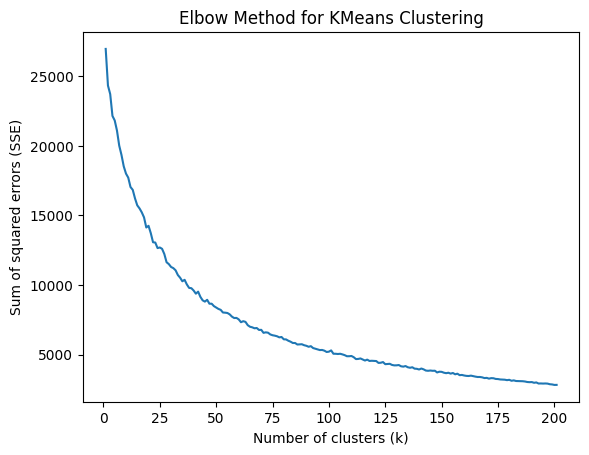

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn
sklearn.set_config(print_changed_only=False)
from time import time
start=time()
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Create a list of different k values to try
k_values = range(1, 202)

# Create an empty list to store the sum of squared errors (SSE) for each k
sse = []

# Loop through each k value
for k in k_values:
  # Create a KMeans model with the current k value
  kmeans = KMeans(n_clusters=k)

  # Fit the model to the data
  kmeans.fit(list(data))

  # Append the SSE for the current k value to the list
  sse.append(kmeans.inertia_)

  if k%20==1:
    print(k, round(time()-start,2), "seconds")

# Plot the SSE for each k value
plt.plot(k_values, sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()


21 356.69 seconds
26 412.04 seconds


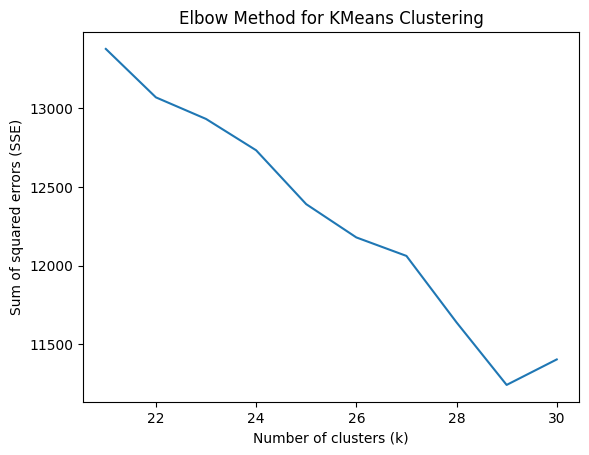

In [ ]:
# Create a list of different k values to try
k_values = range(21, 31)

sse = []

# Loop through each k value
for k in k_values:
  # Create a KMeans model with the current k value
  kmeans = KMeans(n_clusters=k)

  # Fit the model to the data
  kmeans.fit(list(data))

  # Append the SSE for the current k value to the list
  sse.append(kmeans.inertia_)

  if k%5==1:
    print(k, round(time()-start,2), "seconds")

# Plot the SSE for each k value
plt.plot(k_values, sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

81 885.8 seconds
86 1037.45 seconds


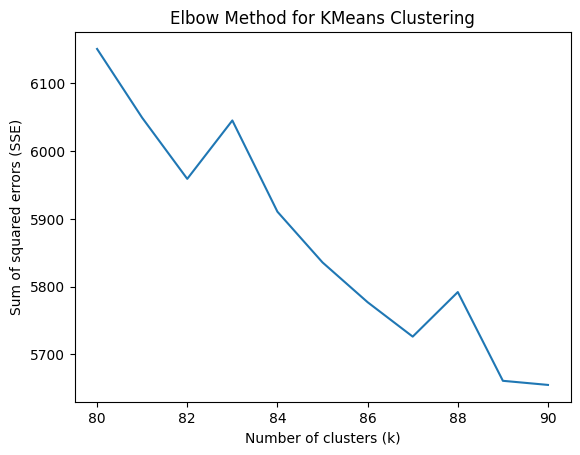

In [ ]:
k_values = range(80, 91)


sse = []

# Loop through each k value
for k in k_values:
  # Create a KMeans model with the current k value
  kmeans = KMeans(n_clusters=k)

  # Fit the model to the data
  kmeans.fit(list(data))

  # Append the SSE for the current k value to the list
  sse.append(kmeans.inertia_)

  if k%5==1:
    print(k, round(time()-start,2), "seconds")

# Plot the SSE for each k value
plt.plot(k_values, sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

41 371.41 seconds
46 450.89 seconds


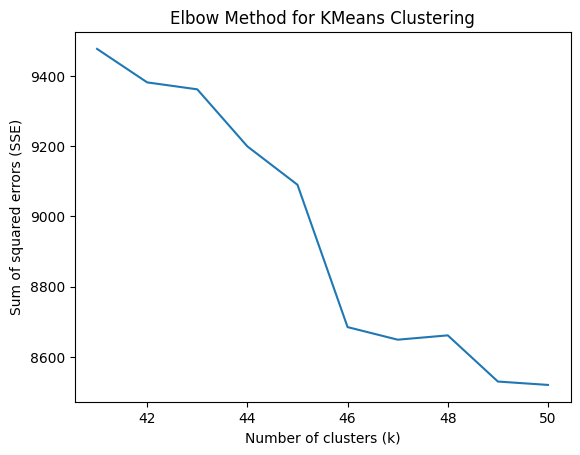

In [ ]:
# Create a list of different k values to try
k_values = range(41, 51)

sse = []

# Loop through each k value
for k in k_values:
  # Create a KMeans model with the current k value
  kmeans = KMeans(n_clusters=k)

  # Fit the model to the data
  kmeans.fit(list(data))

  # Append the SSE for the current k value to the list
  sse.append(kmeans.inertia_)

  if k%5==1:
    print(k, round(time()-start,2), "seconds")

# Plot the SSE for each k value
plt.plot(k_values, sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

# Forming clusters

In [163]:
import numpy as np
def sparse_vectorize(s):
    s = s.split()
    ret = [0]*1151
    for i in s:
        ret[int(i)] = 1
    return ret

data = cat_df["cat_vec"].apply(sparse_vectorize)

print(data)

0        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...
4        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
9995     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9996     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
9998     [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...
9999     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10001    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cat_vec, Length: 8920, dtype: object


In [164]:
from sklearn.cluster import KMeans
import pandas as pd


# k=46
# Create the KMeans model
kmeans = KMeans(n_clusters=46, random_state=42)

# Fit the model to the data
kmeans.fit(list(data))

# Save the cluster labels to a CSV file
clus_df = cat_df.copy()
clus_df["cluster no."] = kmeans.labels_
clus_df.to_csv('cluster_labels.csv', index=False)
# pd.DataFrame(kmeans.labels_).to_csv('cluster_labels.csv', index=False)

In [165]:
# clus_df
# desc_vects
# prod_vects

from sklearn.metrics.pairwise import cosine_similarity

def oos_sub(id, dicti=desc_vects):
    dic = dicti.copy()
    final_df = clus_df.copy()
    final_df = final_df.merge(desc_df, on=["Uniq Id"])
    final_df = final_df.merge(prod_df, on=["Uniq Id"])
    temp_df = final_df.loc[final_df["cluster no."]==int(final_df.iloc[id]["cluster no."])]

    temp_id = final_df.iloc[id]["Uniq Id"]
    # print(dic[str(temp_id)])
    temp_name = str(final_df.iloc[id]["Product Name"])

    temp_ids = list(temp_df["Uniq Id"])
    temp_names = list(temp_df["Product Name"])
    # print(temp_names)

    if str(temp_id) not in dic:
        return "Item not registered", "Item not registered", "Item not registered"
    else:
        temp_vec = np.array(dic[str(temp_id)])
        total_vec = []
        for i in temp_ids:
            if i in dic:
                total_vec.append(np.array(dic[str(i)]))

        # ind = temp_names.index(temp_name)

        similarities = cosine_similarity(temp_vec.reshape(1, -1), total_vec)[0]

        # Sort the similarities in descending order.
        sorted_indices = np.argsort(similarities)[::-1]
        # print(sorted_indices)

        # Get the top N most similar words and their cosine similarity scores.
        top_n_words = [temp_names[i] for i in sorted_indices[1:11]]
        top_n_ids = [temp_ids[i] for i in sorted_indices[1:11]]
        top_n_vectors = [total_vec[i][0] for i in sorted_indices[1:11]]

        return (temp_name, temp_id, temp_vec), (top_n_words, top_n_ids, top_n_vectors)



In [166]:
def print_subs(id, dicti=desc_vects):
    subs = oos_sub(id, dicti)
    print("Out of Stock:")
    print(subs[0][0], "\n", "\n")
    print("Top Recommendations:", "\n")
    print("\n".join(subs[1][0]))


# Querying

## Product Name

In [169]:
print_subs(270, dicti=prod_vects) # enter an id number from 0 to 8700

Out of Stock:
Melissa & Doug Children’s Book - Float-Alongs: Tiny Tugboats (Bath Book + 3 Floating Tugboat Toys, Great Gift for Girls and Boys - Best for Babies and Toddlers, 4, 5, 9 Month Olds, 1 and 2 Year Olds) 
 

Top Recommendations: 

ADI American Dawn Tub Time Tots Kids Hooded Bath Wrap, 2Piece Set, Bear
Award Winning Hape Stacking Veggies Kid's Wooden Skill Learning Game
Janod Spirit Solid Cherry Wood Motorcycle & Side Car Push Toy with Child-Safe Water-Based Lacquer, Rubber Wheels, & Wobbly Philip Dog Driver for Ages 18 Months+
HandiThings DP Dolphin Playground Toy, Red, Blue, Yellow, One Size
Sammons Preston Multi-Colored Beaded Pegs, 300 Multi-Colored Pegs, Cognitive Exercise Game for Training Coordination, Perception, and Motor Sensory Control, Ideal for Young Children
Learning Resources Smart Snacks Shape Sorting Cupcakes & Smart Snacks Rainbow Color Cones, Color Identification, Fine Motor Toy, Ages 2+
Super Wings - Transforming Bello Toy Figure | Plane | Bot | 5” Scale
Ba

## Product Description

In [170]:
print_subs(270, dicti=desc_vects) # enter an id number from 0 to 8700

Out of Stock:
Melissa & Doug Children’s Book - Float-Alongs: Tiny Tugboats (Bath Book + 3 Floating Tugboat Toys, Great Gift for Girls and Boys - Best for Babies and Toddlers, 4, 5, 9 Month Olds, 1 and 2 Year Olds) 
 

Top Recommendations: 

The World of Eric Carle, Duckie Bath Book and Squirty Toy Set
Alex Little Hands String and Beep Kids Toddler Art and Craft Activity
Bright Starts Sesame Street Snack & Stroll Cookie Monster Wooden Pull Toy, Ages 12-36 Months
Melissa & Doug K’s Kids Whose Tail? 8-Page Soft Activity Book, The Original (Great Gift for Girls and Boys - Best for Babies and Toddlers, All Ages)
Baby Einstein Magic Touch Xylophone Wooden Musical Toy, 12 Months +
Singing Machine Kids Candy House Portable Bluetooth Sing-Along Speaker with LED Lit Microphone and Rooftop (SMK470)
Folkmanis Mini Sitting Frog
Hape Twist and Turnables Wooden Building Block Learning Set
John Deere 15" Big Scoop Dump Truck Sandbox Toy with Sand Tools
Alex Discover Button Art Activity Set Kids Art an

In [108]:
subs = oos_sub(321, dicti=prod_vects)
print("\n".join(subs[0]))

MasterPieces Hershey's Shaped Collection Jigsaw Puzzle, Reese's, 500 Pieces
EuroGraphics Seattle City Skyline Puzzle (1000-Piece)
Ceaco Disney Collections Vintage Buttons Jigsaw Puzzle, 750 Pieces
Buffalo Games - Adorable Animals - Picnic Raiders - 300 Large Piece Jigsaw Puzzle
Bigjigs Toys BJ756 Inset Puzzle Numbers
BePuzzled Mickey/Minnie Gearshift Puzzle (4 Pieces)
Ceaco Disney Descendants Mal & Evie Jigsaw Puzzle, 250 Pieces
Buffalo Games - Darrell Bush - Coastal Twilight - 1000 Piece Jigsaw Puzzle
MasterPieces NFL Houston Texans Stadium Panoramic Jigsaw Puzzle, 1000 Pieces
Avanti - Kitten Bouquet Puzzle - 300 Pieces


In [107]:
subs = oos_sub(69)
print("\n".join(subs[0]))

Nat and Jules Standing Small Corgi Dog Children's Plush Stuffed Animal Toy
DC Super Hero Girls: Supergirl Mini Plush Dolls
Happy Trails Interactive Plush Puppy Toy– Battery Operated Dog That Walks, Barks & Does Back Flips, Soft & Snuggly Fur, Stuffed Animal Robot
Linzy Plush 16" Yellow Aissa Doll Soft Rag Doll
The Puppet Company - Golf Club Covers - Elephant
Wild Republic Red Panda Plush, Stuffed Animal, Plush Toy, Kids Gifts, Zoo, 15"
Mary Meyer Super Soft Stuffed Animal Security Blanket, Fizzy Frog, 13 x 13-Inches
Kaloo Tendresse My First Fabric Doll Eliott K 10” Soft Plush Figure in White Shirt, Blue Jeans, and Red Hat with Baby Safe Embroidered Face Machine Washable for Ages 0+
KIDS PREFERRED Peter Rabbit Stuffed Animal Plush Bunny, 21 Inches
Wild Republic Common Langur w/baby Plush, Monkey Stuffed Animal, Plush Toy, Gifts for Kids, Hanging 20 Inches


In [103]:
print((err[-1297:]))

[8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 886